In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm

from scipy import optimize

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow, LinearFlow
from nflib.coupling_flows import AffineHalfFlow, MLP_Generator, DimensionMixer
##### Linear units are worst, use swish type activation
from nflib.inn_flow import iMLP_Flow, ReLU, LeakyReLU, Swish, TanhLU, iMLP_Flow_x
from nflib.res_flow import ResidualFlow

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform

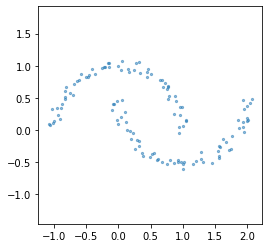

In [4]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

d = DatasetMoons()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [5]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

flows = [
#     ActNorm(2),
    iMLP_Flow_x(2, 100, activation=TanhLU),
#     ResidualFlow(2, [100], activation=TanhLU),
#     ActNorm(2),
    iMLP_Flow_x(2, 100, activation=TanhLU),
#     ResidualFlow(2, [100], activation=TanhLU),
        ]
model = NormalizingFlow(flows, prior)

 29%|██▉       | 29/100 [00:00<00:00, 281.53it/s]

tensor([-1.])
Initializing to have all same sign of determinant


 35%|███▌      | 35/100 [00:00<00:00, 341.88it/s]

Det Min Max tensor(-1.2375) tensor(-0.4618)
tensor([1.])
Initializing to have all same sign of determinant


100%|██████████| 100/100 [00:00<00:00, 351.51it/s]

Det Min Max tensor(0.3698) tensor(1.1837)


In [6]:
# model.flow.flows[0].sign

In [7]:
model

NormalizingFlow(
  (flow): SequentialFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): iMLP_Flow_x(
        (layers): ModuleList(
          (0): Linear(in_features=2, out_features=100, bias=True)
          (1): TanhLU()
          (2): Linear(in_features=100, out_features=2, bias=True)
        )
      )
      (2): ActNorm()
      (3): iMLP_Flow_x(
        (layers): ModuleList(
          (0): Linear(in_features=2, out_features=100, bias=True)
          (1): TanhLU()
          (2): Linear(in_features=100, out_features=2, bias=True)
        )
      )
    )
  )
)

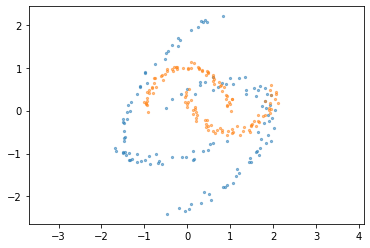

In [8]:
x = d.sample(128)
z, logDetJ = model.flow(x, True)
# z = flows[0](x)
z = z.data.detach()
plt.scatter(z[:,0], z[:,1], s=5, alpha=0.5)
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [9]:
# jpt text to stop execution

## Model Train

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # todo tune WD
# optimizer = optim.SGD(model.parameters(), lr=0.1)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1012


In [11]:
# def get_NLL(logdet, prior_log):
#     y = prior_logP + logDetJ
#     y.register_hook(clip_gradient_back)
#     return -torch.mean(y)

# def clip_gradient_back(grad):
#     global model
#     clipval = func_det_clipper(model.flow.flows[0].detJ)
#     clipval = torch.clamp_max(clipval, 1)
#     y = torch.minimum(torch.maximum(grad, -clipval), clipval)

#     print("Grad orig mean, std", grad.mean(), grad.std())
#     print("Grad clip mean, std", y.mean(), y.std())
#     print(model.flow.flows[0].detJ.min(), clipval.min())
#     print(model.flow.flows[0].detJ.max(), clipval.max())
#     return y

# def func_det_penalty(detJ):
#     return 8*(torch.minimum(detJ-0.2, torch.Tensor([0]))**2)

# def func_det_clipper(detJ):
#     return 8*(torch.maximum(detJ-0.2, torch.Tensor([0]))**3)

In [12]:
# class GradManager():
    
#     def __init__(self, iNN):
#         self.iNN = iNN
        
#     def det_penalty(self):
#         dp = func_det_penalty(self.iNN.detJ)
        
#         ### backprop
#         dp.mean().backward(retain_graph=True)
#         for p in self.iNN.parameters():
#             if p.grad is not None:
#                 p.grad_det = p.grad.detach()
#                 p.grad = None
#             else:
#                 p.grad_det = None
            
#     def NLL_penalty(self, logDetJ, prior_logP):
#         y = prior_logP + logDetJ
# #         y.register_hook(self.clip_gradient_back)
#         NLL = -torch.mean(y)
#         NLL.backward()
        
#         ## analyze the gradients now.
#         for p in self.iNN.parameters():
# #             print(p.grad_det)
#             if p.grad_det is not None:
#                 mask = torch.abs(p.grad_det)>1e-5
# #                 mask = ~(torch.sign(p.grad) == torch.sign(p.grad_det))
# #                 print(mask)
#                 p.grad[mask] = p.grad_det[mask]
# #                 print(mask)

#         return float(NLL)
    
#     def clip_gradient_back(self, grad):
#         clipval = func_det_clipper(self.iNN.detJ[:len(grad)])
#         clipval = torch.clamp_max(clipval, 0.1)
#         y = torch.minimum(torch.maximum(grad, -clipval), clipval)
#         return y

In [13]:
# imlp = model.flow.flows[0]

In [14]:
def gradient_clip_backward(model):
    for f in model.flow.flows:
        if isinstance(f, iMLP_Flow_x):
            f.clip_output_gradients()
            
def print_dets_minmax(model):
    for i, f in enumerate(model.flow.flows):
        if isinstance(f, iMLP_Flow_x):
            print(f"Det {i}: {float(f._dets.min())}, {float(f._dets.max())}, penalty: {float(f.det_penalty)}")

In [15]:
model.train()
losses = []
NUM = 512
for k in tqdm(range(1000*2+1)):
    optimizer.zero_grad()
    
    x = d.sample(NUM)
    rand = torch.rand(50, 2)*6-3
    x = torch.cat([x, rand], dim=0)
    
    z, logDetJ, prior_logP = model(x, True)
    loss = -torch.mean(logDetJ[:NUM]+prior_logP[:NUM]) # NLL with hook for gradient clip
    loss.backward()
    gradient_clip_backward(model)
    optimizer.step()

    if k % 200 == 0:
        losses.append(float(loss))
        print("Loss:", k, losses[-1])
        print("logDetJ:", logDetJ.data.min(), logDetJ.data.max())
        print_dets_minmax(model)

  0%|          | 0/2001 [00:00<?, ?it/s]

Loss: 0 2.182007074356079
logDetJ: tensor(-0.5552) tensor(1.5150)
Det 1: -1.7506558895111084, -0.1414148211479187, penalty: 0.2770865559577942
Det 3: 0.12576508522033691, 1.561716079711914, penalty: 0.3473883271217346


 10%|█         | 205/2001 [00:08<01:08, 26.14it/s]

Loss: 200 2.085712432861328
logDetJ: tensor(-0.2900) tensor(1.5685)
Det 1: -2.378681182861328, -0.25804123282432556, penalty: 0.017765408381819725
Det 3: 0.3259836435317993, 2.2183380126953125, penalty: 0.0


 20%|██        | 403/2001 [00:16<01:07, 23.56it/s]

Loss: 400 1.9496955871582031
logDetJ: tensor(-0.3390) tensor(1.2026)
Det 1: -2.2866828441619873, -0.34653201699256897, penalty: 0.0
Det 3: 0.28131240606307983, 1.976426601409912, penalty: 0.0035355454310774803


 30%|███       | 604/2001 [00:24<00:58, 23.77it/s]

Loss: 600 1.9178766012191772
logDetJ: tensor(-0.1857) tensor(1.1740)
Det 1: -2.2740540504455566, -0.3830162286758423, penalty: 0.0
Det 3: 0.3104444146156311, 2.09993052482605, penalty: 0.0


 40%|████      | 805/2001 [00:33<00:52, 22.74it/s]

Loss: 800 1.867537021636963
logDetJ: tensor(-0.0302) tensor(1.2495)
Det 1: -2.281069040298462, -0.3704174757003784, penalty: 0.0
Det 3: 0.3385302722454071, 2.325011730194092, penalty: 0.0


 50%|█████     | 1005/2001 [00:43<00:43, 22.91it/s]

Loss: 1000 1.7988214492797852
logDetJ: tensor(0.2232) tensor(1.6177)
Det 1: -2.9289660453796387, -0.47067955136299133, penalty: 0.0
Det 3: 0.3852560818195343, 2.5675196647644043, penalty: 0.0


 60%|██████    | 1202/2001 [00:54<00:57, 13.79it/s]

Loss: 1200 1.6131147146224976
logDetJ: tensor(-0.3970) tensor(2.3519)
Det 1: -3.875221014022827, -0.5682264566421509, penalty: 0.0
Det 3: 0.30588993430137634, 3.810704231262207, penalty: 0.0


 70%|███████   | 1405/2001 [01:03<00:25, 23.36it/s]

Loss: 1400 1.5538522005081177
logDetJ: tensor(-0.0264) tensor(2.6022)
Det 1: -4.023015022277832, -0.6598056554794312, penalty: 0.0
Det 3: 0.37076109647750854, 4.930452823638916, penalty: 0.0


 80%|████████  | 1603/2001 [01:12<00:17, 23.30it/s]

Loss: 1600 1.5204143524169922
logDetJ: tensor(0.0315) tensor(3.0360)
Det 1: -4.928956508636475, -0.5720223188400269, penalty: 0.0
Det 3: 0.3552042543888092, 5.580383777618408, penalty: 0.0


 90%|█████████ | 1804/2001 [01:21<00:08, 22.49it/s]

Loss: 1800 1.4580333232879639
logDetJ: tensor(0.0196) tensor(3.2839)
Det 1: -5.914520263671875, -0.37898650765419006, penalty: 0.0
Det 3: 0.3380375802516937, 6.297481060028076, penalty: 0.0


100%|██████████| 2001/2001 [01:30<00:00, 22.18it/s]

Loss: 2000 1.4023306369781494
logDetJ: tensor(0.0188) tensor(3.6580)
Det 1: -8.82833480834961, -0.49749284982681274, penalty: 0.0
Det 3: 0.2927529513835907, 6.565264701843262, penalty: 0.0005890195025131106


In [16]:
# print(imlp._dets.sort()[0])

In [17]:
# for p in imlp.parameters():
#     print("gD",p.grad_det)
#     clipval = (1-p.grad_det.data.abs())**200
#     print("CV",clipval)

In [18]:
asdfsdf
z.backward(retain_graph=True)

NameError: name 'asdfsdf' is not defined

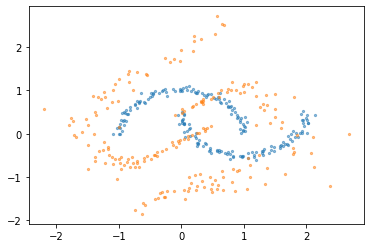

In [19]:
with torch.no_grad():
    x = d.sample(200)
    y = model.flow(x, False)
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.scatter(y[:,0], y[:,1], s=5, alpha=0.5)   

Solution found in 9 steps


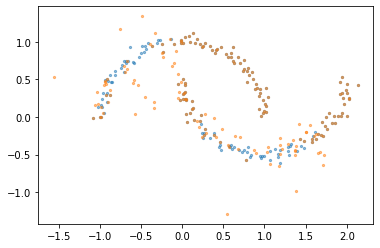

In [20]:
g = lambda z: y - model.flow._forward_no_logDetJ(z)
# find_fixed_point(g, torch.zeros_like(y))
iter_root = nflib.inn_flow.broyden(g, torch.zeros_like(y), threshold=100, eps=1e-7)
_x = iter_root["result"]

print(f"Solution found in {iter_root['nstep']} steps")

plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.scatter(_x[:,0], _x[:,1], s=5, alpha=0.5)
plt.show()

  2%|▏         | 3/200 [00:00<00:08, 22.60it/s]

broyden1


100%|██████████| 200/200 [00:06<00:00, 33.31it/s]


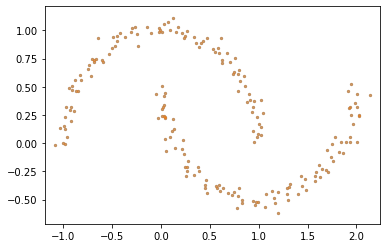

In [21]:
# g = lambda z: y - flows[0]._forward_no_logDetJ(z)
import warnings
warnings.filterwarnings(action='ignore',module='sklearn')
# from scipy.linalg import LinAlgWarning 
# warnings.filterwarnings("ignore",category= LinAlgWarning, module='sklearn')

def func_g(z, y):
    z = torch.Tensor(z)
    _x = y - model.flow._forward_no_logDetJ(z)
    return _x.data.numpy()


methods = ["hybr", "lm", "broyden1", "broyden2", "anderson", "linearmixing",
           "diagbroyden", "excitingmixing", "krylov", "df-sane"]

### best methods broyden1,2, anderson(produces error message), excitingmixing(goodenough)
### diagbroyden, krylov produced error when not invertible. 
meth = methods[2]
print(meth)
_x = torch.empty_like(y)
for i in tqdm(range(len(y))):
    out = optimize.root(func_g, torch.zeros_like(y)[i] ,args=(y[i]), method=meth)['x']
    _x[i] = torch.Tensor(out)
    
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.scatter(_x[:,0], _x[:,1], s=5, alpha=0.5)
plt.axis([x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1])
plt.show()

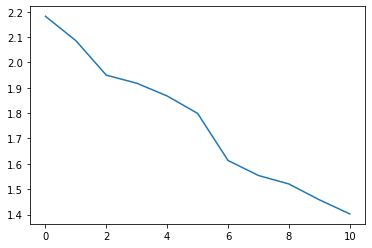

In [22]:
plt.plot(losses)

tensor(4.1415, grad_fn=<NegBackward>)
torch.Size([400, 2])


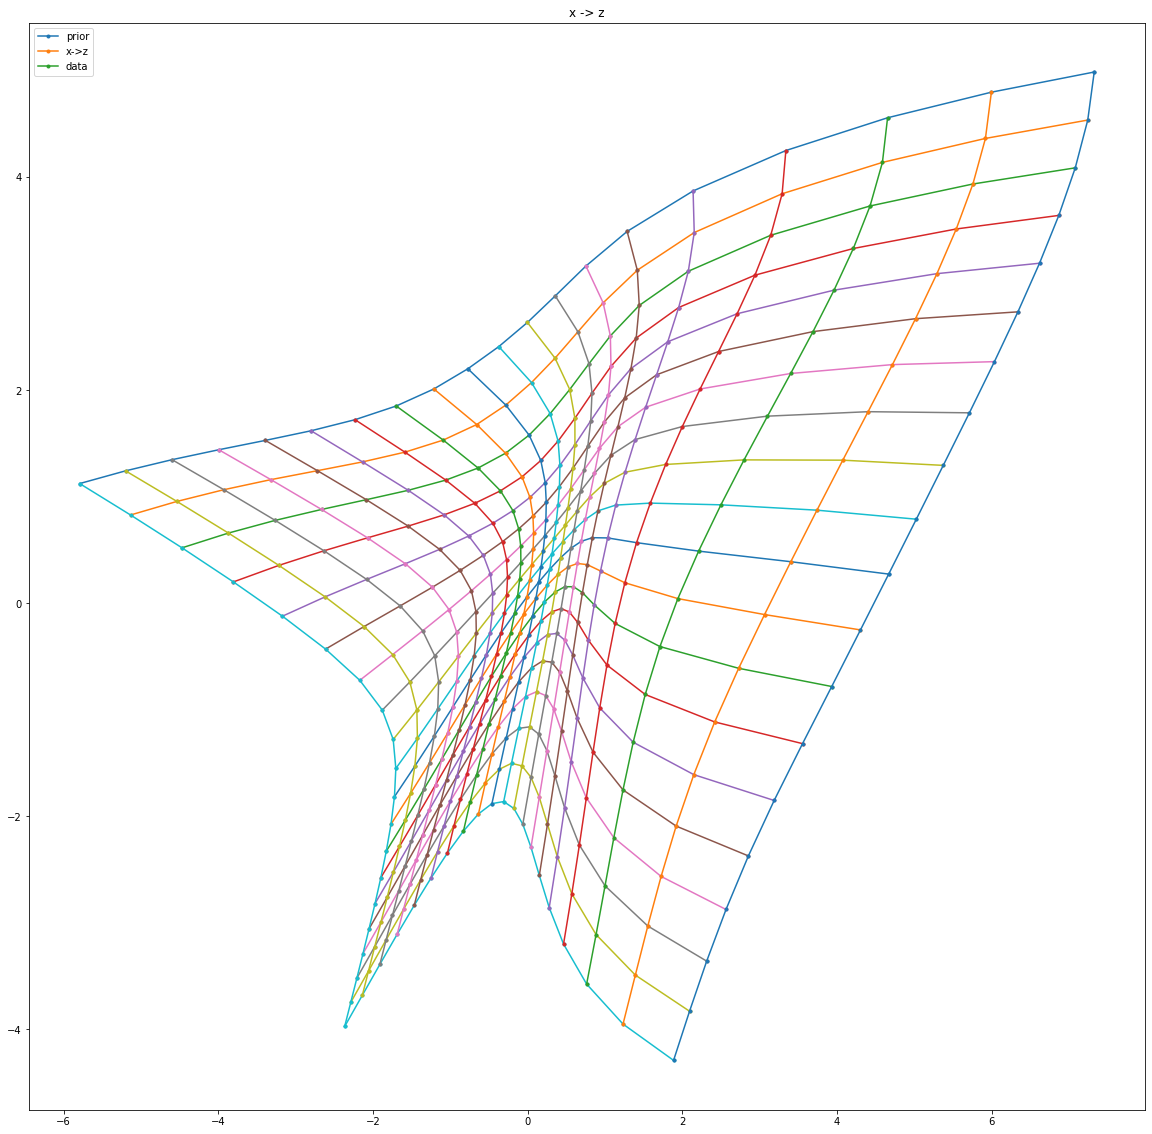

In [23]:
model.eval()

ng = 20
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x = torch.Tensor(xy)
z, logDetJ, prior_logP = model(x, True)

print(-torch.mean(prior_logP + logDetJ))
print(z.shape)

x = x.detach().numpy()
z = z.detach().numpy()
plt.figure(figsize=(20,20))
plt.scatter(z[:,0], z[:,1], c='r', s=5)
z = z.reshape(ng, ng, -1)
for i in range(ng):
    plt.plot(z[:, i, 0], z[:, i, 1], marker='.')
for i in range(ng):
    plt.plot(z[i, :, 0], z[i, :, 1], marker='.')
    

# plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.title('x -> z')
plt.savefig("_temp.svg")

In [ ]:
# x = d.sample(128*5)
# model(x, True, True)[1]

In [ ]:
# logDetJ

Text(0.5, 1.0, 'x -> z')

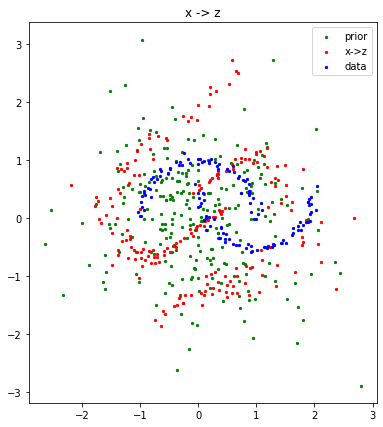

In [24]:
model.eval()

_x = d.sample(128)
x = _x.detach().numpy()
z = y.detach().numpy()
p = model.prior.sample((128*2,))
plt.figure(figsize=(7,7))
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

Text(0.5, 1.0, 'z -> x')

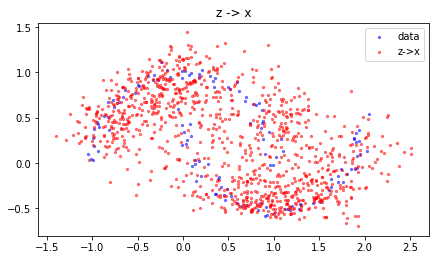

In [25]:
plt.figure(figsize=(7,7))

_x = model.sample(128*8)

# z = model.prior.sample((128,))
# _x = torch.empty_like(z)
# for i in tqdm(range(len(z))):
#     out = optimize.root(func_g, torch.zeros_like(z)[i] ,args=(z[i]), method=meth)['x']
#     _x[i] = torch.Tensor(out)

_x = _x.detach().numpy()
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(_x[:,0], _x[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')
# plt.axis([z[:,0].min()-0.1,z[:,0].max()+0.1,z[:,1].min()-0.1,z[:,1].max()+0.1])

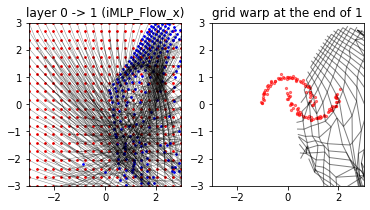

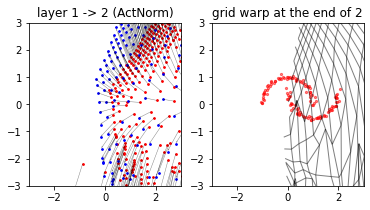

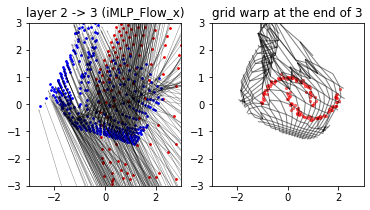

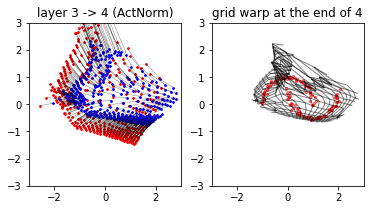

In [26]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

zs, log_dets = model.inverse(xy, True, intermediate=True)

backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 3))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
    axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)

In [ ]:
# dir(model.flow.flows[0].resblock[0]._forward_pre_hooks[0])

In [ ]:
# model(x)

In [ ]:
W1 = torch.randn(10, 2, 4)
W2 = torch.randn(10, 4, 2)

In [ ]:
torch.det(W1@W2)

In [ ]:
torch.det((W1@W2)@(W1@W2).transpose(1,2))

In [ ]:
torch.det(W1@W1.transpose(1,2))**0.5

In [ ]:
torch.det(W2.transpose(1,2)@W2)**(-0.5)

In [ ]:
J = torch.eye(2).expand(10,2,2)
j1 = J@W1
j2 = j1*(torch.bernoulli(torch.ones(10, 4)*0.5).unsqueeze(1)+0.001)

In [ ]:
j3 = j2@W2

In [ ]:
d = torch.det(j3)
print(torch.sign(d))
print(d)

In [ ]:
torch.bernoulli(torch.ones(10,4)*0.5).type(torch.long).unsqueeze(1).shape

In [ ]:
torch.Tensor([-0.1, 1])[torch.bernoulli(torch.ones(10*4)*0.5).type(torch.long)]

In [ ]:
W1*(torch.bernoulli(torch.ones(10, 4)*0.5).unsqueeze(1))

In [ ]:
torch.randn(1,3,4)*(torch.randn(2,1,4)>0)